# COGS 108 - EDA Checkpoint

# Names

- Tyler Le
- Aditya Tomar
- William Lynch
- Michael Mao
- Natalie Quach

<a id='research_question'></a>
# Research Question

Is there a positive correlation between the cost of living and the impact of natural disasters in terms of injuries, casualties, and property damage per capita at the county level? Furthermore, in which state does the impact of natural disasters affect cost of living the most?

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import os
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm # progress bar for .apply()
from pathlib import Path
%config InlineBackend.figure_format ='retina'

# Data Cleaning

Describe your data cleaning steps here.

In [2]:
# The following code is used to clean the datasets in the "nat_disast_bystate_deaths_cost" folder

# change directory as needed on local computer
directory = '/Users/nataliequach/Downloads/Group013-Wi22/datasets/nat_disast_bystate_deaths_cost'

dfs = []

# create a list of df by looping through the folder
for filename in os.listdir(directory):
    # print the filename so we know which filename corresponds to each entry in the dfs list
    print("filename: ", filename)
    if filename.endswith('.csv'):
        f = os.path.join(directory, filename)
        dfs.append(pd.read_csv(f))
        
# find rows we need to drop in each df
print('-- Rows to get rid of --')
for df in dfs:
    print(df[df.isnull().any(axis=1)].index)
print('-- Rows to get rid of --')
       
# get rid of null rows and rename columns       
for index, df in enumerate(dfs):
    if index == 5:
        df.drop(labels= [0, 1, 2], inplace=True)
    else:
        df.drop(labels= [0, 1, 2, 42], inplace=True)
        
    df.columns = ['state', 'fatalities', 'injuries', 'property_damage', 'crop_damage',
                       'total_damage']
    
# get rid of null rows unique to each df    
dfs[0] = dfs[0].drop(labels= [71])
dfs[1] = dfs[1].drop(labels= [72])
dfs[2] = dfs[2].drop(labels= [72])
dfs[3] = dfs[3].drop(labels= [72])
dfs[4] = dfs[4].drop(labels= [70])

print('-- Number of NaNs --')
print(dfs[0].isna().sum().sum())
print(dfs[1].isna().sum().sum())
print(dfs[2].isna().sum().sum())
print(dfs[3].isna().sum().sum())
print(dfs[4].isna().sum().sum())
print(dfs[5].isna().sum().sum())
print('-- Number of NaNs --')

# make each column the correct data type
for df in dfs:
    df[['fatalities','injuries', 'property_damage','crop_damage', 'total_damage']] = df[['fatalities','injuries', 'property_damage','crop_damage', 'total_damage']].apply(pd.to_numeric)
    print('--')
    print(df.dtypes)
    print('--')



filename:  .DS_Store
filename:  disaster_2015.csv
filename:  disaster_2017.csv
filename:  disaster_2016.csv
filename:  .ipynb_checkpoints
filename:  disaster_2018.csv
filename:  disaster_2019.csv
filename:  disaster_2020.csv
filename:  READ_THIS.txt
-- Rows to get rid of --
Int64Index([1, 2, 42, 71], dtype='int64')
Int64Index([1, 2, 42, 72], dtype='int64')
Int64Index([1, 2, 42, 72], dtype='int64')
Int64Index([1, 2, 42, 72], dtype='int64')
Int64Index([1, 2, 42, 70], dtype='int64')
Int64Index([1, 2], dtype='int64')
-- Rows to get rid of --
-- Number of NaNs --
0
0
0
0
0
0
-- Number of NaNs --
--
state               object
fatalities           int64
injuries             int64
property_damage    float64
crop_damage        float64
total_damage       float64
dtype: object
--
--
state               object
fatalities           int64
injuries             int64
property_damage    float64
crop_damage        float64
total_damage       float64
dtype: object
--
--
state               object
fataliti

In [3]:
dfs[0]

,state,fatalities,injuries,property_damage,crop_damage,total_damage
3,AK (Alaska),7,8,25.00,0.00,25.00
4,AL (Alabama),13,17,14.79,0.00,14.79
5,AM (Atlantic South),3,0,0.00,0.00,0.00
6,AN (Atlantic North),4,5,0.00,0.00,0.00
7,AR (Arkansas),10,337,18.25,27.26,45.51
...,...,...,...,...,...,...
66,WA (Washington),8,7,28.94,0.02,28.96
67,WI (Wisconsin),4,8,8.73,0.01,8.74
68,WV (West Virginia),4,2,20.73,0.00,20.73
69,WY (Wyoming),2,5,10.35,0.25,10.60


In [4]:
# separate state and its abbreviation
for df in dfs:
    df[['state_abbrv', 'state']] = df['state'].str.split(' ', n=1, expand=True)
    df['state'] = df['state'].str.replace('(','')
    df['state'] = df['state'].str.replace(')','')

In [5]:
dfs[0].head(3)

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
3,Alaska,7,8,25.00,0.0,25.00,AK
4,Alabama,13,17,14.79,0.0,14.79,AL
5,Atlantic South,3,0,0.00,0.0,0.00,AM


In [6]:
states = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
           'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
           'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
           'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
           'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

# remove all columns where state_abbrv is not in the above list of US states. reset index at end
for idx, df in enumerate(dfs):
    dfs[idx] = dfs[idx][dfs[idx]['state_abbrv'].isin(states)]
    dfs[idx] = dfs[idx].reset_index(drop=True)

In [44]:
disaster2015 = dfs[0]
disaster2015

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,7,8,25.00,0.00,25.00,AK
1,Alabama,13,17,14.79,0.00,14.79,AL
2,Arkansas,10,337,18.25,27.26,45.51,AR
3,Arizona,8,58,10.74,0.05,10.79,AZ
4,California,12,40,108.51,0.20,108.71,CA
5,Colorado,3,21,8.21,1.82,10.03,CO
6,Connecticut,2,3,1.50,0.00,1.50,CT
7,Delaware,0,4,0.55,0.00,0.55,DE
8,Florida,28,81,26.00,1.00,27.00,FL
9,Georgia,5,21,33.51,0.01,33.53,GA


In [8]:
disaster2016 = dfs[2]
disaster2016

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,4,2,0.20,0.00,0.20,AK
1,Alabama,7,32,4.31,0.00,4.31,AL
2,Arkansas,2,8,13.38,0.20,13.58,AR
3,Arizona,11,36,6.33,4.60,10.93,AZ
4,California,22,29,74.31,0.08,74.38,CA
5,Colorado,5,14,0.86,0.04,0.90,CO
6,Connecticut,0,4,1.75,0.00,1.75,CT
7,Delaware,0,18,0.04,0.00,0.04,DE
8,Florida,31,53,3116.31,0.01,3116.32,FL
9,Georgia,11,25,35.25,3.00,38.25,GA


In [9]:
disaster2017 = dfs[1]
disaster2017

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,2,0,6.53,0.00,6.53,AK
1,Alabama,14,35,31.59,0.00,31.59,AL
2,Arkansas,9,17,37.58,23.51,61.09,AR
3,Arizona,13,8,11.15,0.00,11.15,AZ
4,California,43,93,866.95,0.12,867.06,CA
5,Colorado,4,6,1426.48,0.29,1426.78,CO
6,Connecticut,2,3,1.44,0.01,1.45,CT
7,Delaware,0,5,0.00,0.00,0.00,DE
8,Florida,32,118,3922.58,634.85,4557.43,FL
9,Georgia,20,162,449.19,231.65,680.84,GA


In [10]:
disaster2018 = dfs[3]
disaster2018

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,0,0,3.89,0.00,3.89,AK
1,Alabama,6,35,8.34,0.00,8.34,AL
2,Arkansas,3,12,19.82,0.04,19.86,AR
3,Arizona,4,44,67.45,0.00,67.45,AZ
4,California,128,318,19500.67,150.00,19650.67,CA
5,Colorado,13,9,669.22,0.21,669.43,CO
6,Connecticut,3,6,8.19,0.00,8.19,CT
7,Delaware,0,0,0.00,0.00,0.00,DE
8,Florida,43,51,9909.30,1500.00,11409.30,FL
9,Georgia,6,21,1545.98,2888.00,4433.99,GA


In [11]:
disaster2019 = dfs[4]
disaster2019

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,0,0,8.55,0.00,8.55,AK
1,Alabama,31,109,0.98,0.00,0.98,AL
2,Arkansas,6,22,24.94,4.18,29.12,AR
3,Arizona,149,17,15.07,0.00,15.07,AZ
4,California,33,84,144.22,20.84,165.05,CA
5,Colorado,17,7,1.42,0.39,1.81,CO
6,Connecticut,3,2,0.80,0.00,0.80,CT
7,Delaware,0,4,0.00,0.00,0.00,DE
8,Florida,33,37,27.58,0.00,27.58,FL
9,Georgia,3,16,20.95,0.01,20.95,GA


In [12]:
disaster2020 = dfs[5]
disaster2020

,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,Alaska,5,0,35.85,0.00,35.85,AK
1,Alabama,11,27,313.39,2.08,315.47,AL
2,Arkansas,2,32,313.81,1.41,315.21,AR
3,Arizona,45,8,3.95,0.00,3.95,AZ
4,California,46,253,41.49,0.00,41.49,CA
5,Colorado,12,9,295.98,30.00,325.98,CO
6,Connecticut,1,1,56.40,0.00,56.40,CT
7,Delaware,0,0,0.00,0.00,0.00,DE
8,Florida,19,29,361.30,90.03,451.33,FL
9,Georgia,17,48,33.95,0.01,33.96,GA


In [13]:
# The following code was used to make new csv files for cleaned disaster datasets

# filepath2015 = Path('datasets/cleaned/cleaned_disaster2015.csv') 
# filepath2015.parent.mkdir(parents=True, exist_ok=True)  
# disaster2015.to_csv(filepath2015)  

# filepath2016 = Path('datasets/cleaned/cleaned_disaster2016.csv') 
# filepath2016.parent.mkdir(parents=True, exist_ok=True)  
# disaster2016.to_csv(filepath2016) 

# filepath2017 = Path('datasets/cleaned/cleaned_disaster2017.csv') 
# filepath2017.parent.mkdir(parents=True, exist_ok=True)  
# disaster2017.to_csv(filepath2017) 

# filepath2018 = Path('datasets/cleaned/cleaned_disaster2018.csv') 
# filepath2018.parent.mkdir(parents=True, exist_ok=True)  
# disaster2018.to_csv(filepath2018) 

# filepath2019 = Path('datasets/cleaned/cleaned_disaster2019.csv') 
# filepath2019.parent.mkdir(parents=True, exist_ok=True)  
# disaster2019.to_csv(filepath2019) 

# filepath2020 = Path('datasets/cleaned/cleaned_disaster2020.csv') 
# filepath2020.parent.mkdir(parents=True, exist_ok=True)  
# disaster2020.to_csv(filepath2020) 

In [14]:
# This code block combines the disaster datasets from 2015 - 2020

filepath = Path('datasets/cleaned')

cleaned_files = filepath.glob('cleaned_disaster*.csv')

# create list to store dataframes
df_list = []

for file in cleaned_files:
    # get year from filename (last 4 characters)
    year = (file.stem)[-4:]
    
    # read the file and add column names
    file_to_add= pd.read_csv(file, header=0, names=['state', 'fatalities', 'injuries', 'property_damage', 
                                           'crop_damage', 'total_damage', 'state_abbrv'])
    
    # insert year column
    file_to_add.insert(0, 'year', int(year))
    
    # append to the list
    df_list.append(file_to_add)
    
# create one dataframe from the list of dataframes
combined_disasters = pd.concat(df_list).reset_index(drop=True)

In [15]:
combined_disasters

,year,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,2018,Alaska,0,0,3.89,0.00,3.89,AK
1,2018,Alabama,6,35,8.34,0.00,8.34,AL
2,2018,Arkansas,3,12,19.82,0.04,19.86,AR
3,2018,Arizona,4,44,67.45,0.00,67.45,AZ
4,2018,California,128,318,19500.67,150.00,19650.67,CA
...,...,...,...,...,...,...,...,...
295,2015,Vermont,0,0,3.55,0.00,3.55,VT
296,2015,Washington,8,7,28.94,0.02,28.96,WA
297,2015,Wisconsin,4,8,8.73,0.01,8.74,WI
298,2015,West Virginia,4,2,20.73,0.00,20.73,WV


In [16]:
combined_disasters = combined_disasters.sort_values(by= ['year', 'state'])
combined_disasters

,year,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
251,2015,Alabama,13,17,14.79,0.00,14.79,AL
250,2015,Alaska,7,8,25.00,0.00,25.00,AK
253,2015,Arizona,8,58,10.74,0.05,10.79,AZ
252,2015,Arkansas,10,337,18.25,27.26,45.51,AR
254,2015,California,12,40,108.51,0.20,108.71,CA
...,...,...,...,...,...,...,...,...
144,2020,Virginia,1,14,41.29,0.10,41.39,VA
146,2020,Washington,5,11,1340.16,0.52,1340.68,WA
148,2020,West Virginia,1,3,5.62,0.00,5.62,WV
147,2020,Wisconsin,11,1,79.28,0.26,79.54,WI


In [17]:
combined_disasters = combined_disasters.reset_index(drop= True)
combined_disasters

,year,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,2015,Alabama,13,17,14.79,0.00,14.79,AL
1,2015,Alaska,7,8,25.00,0.00,25.00,AK
2,2015,Arizona,8,58,10.74,0.05,10.79,AZ
3,2015,Arkansas,10,337,18.25,27.26,45.51,AR
4,2015,California,12,40,108.51,0.20,108.71,CA
...,...,...,...,...,...,...,...,...
295,2020,Virginia,1,14,41.29,0.10,41.39,VA
296,2020,Washington,5,11,1340.16,0.52,1340.68,WA
297,2020,West Virginia,1,3,5.62,0.00,5.62,WV
298,2020,Wisconsin,11,1,79.28,0.26,79.54,WI


In [18]:
# load dataset with cost of living
# cost_of_living = pd.read_csv('datasets/cleaned/col_updated.csv')
# cost_of_living

In [19]:
# load dataset with cost of living per state
cost_of_living_state = pd.read_csv('datasets/col_bystate.csv')
cost_of_living_state

,State,costIndex,groceryCost,housingCost,utilitiesCost,transportationCost,miscCost
0,Mississippi,86.1,93.2,666.0,92.3,89.1,91.4
1,Arkansas,86.9,92.5,75.6,90.7,91.0,97.4
2,Oklahoma,87.0,94.6,73.0,93.4,92.5,93.5
3,Missouri,87.1,95.4,78.3,96.3,90.4,95.8
4,New Mexico,87.5,94.6,84.4,89.9,98.5,91.9
5,Tennessee,88.7,93.0,79.4,91.7,86.0,92.9
6,Michigan,88.9,91.0,80.2,98.5,101.8,96.4
7,Kansas,89.0,92.6,70.0,100.1,95.4,90.3
8,Georgia,89.2,96.3,74.3,90.3,95.7,96.6
9,Wyoming,89.3,103.5,81.7,87.4,94.5,105.5


In [20]:
cost_of_living_state.dtypes

State                  object
costIndex             float64
groceryCost           float64
housingCost           float64
utilitiesCost         float64
transportationCost    float64
miscCost              float64
dtype: object

In [21]:
# check for missing values
cost_of_living_state.isna().sum()

State                 0
costIndex             0
groceryCost           0
housingCost           0
utilitiesCost         0
transportationCost    0
miscCost              0
dtype: int64

In [22]:
# rename State column and drop columns that aren't needed
cost_of_living_state = cost_of_living_state.rename(columns = {"State": "state"})
cost_of_living_state = cost_of_living_state.drop(columns= ['groceryCost', 'housingCost', 'utilitiesCost', 
                                   'transportationCost', 'miscCost'])
cost_of_living_state

,state,costIndex
0,Mississippi,86.1
1,Arkansas,86.9
2,Oklahoma,87.0
3,Missouri,87.1
4,New Mexico,87.5
5,Tennessee,88.7
6,Michigan,88.9
7,Kansas,89.0
8,Georgia,89.2
9,Wyoming,89.3


In [23]:
# create dataframe with all columns averaged grouped by state
average_df = combined_disasters.groupby(by= 'state', as_index= False).mean()
average_df

,state,year,fatalities,injuries,property_damage,crop_damage,total_damage
0,Alabama,2017.5,13.666667,42.500000,62.233333,0.346667,62.580000
1,Alaska,2017.5,3.000000,1.666667,13.336667,0.000000,13.336667
2,Arizona,2017.5,38.333333,28.500000,19.115000,0.775000,19.890000
3,Arkansas,2017.5,5.333333,71.333333,71.296667,9.433333,80.728333
4,California,2017.5,47.333333,136.166667,3456.025000,28.540000,3484.560000
5,Colorado,2017.5,9.000000,11.000000,400.361667,5.458333,405.821667
6,Connecticut,2017.5,1.833333,3.166667,11.680000,0.001667,11.681667
7,Delaware,2017.5,0.000000,5.166667,0.098333,0.000000,0.098333
8,Florida,2017.5,31.000000,61.500000,2893.845000,370.981667,3264.826667
9,Georgia,2017.5,10.333333,48.833333,353.138333,520.446667,873.586667


In [24]:
# drop year column
average_df = average_df.drop(columns= 'year')
average_df

,state,fatalities,injuries,property_damage,crop_damage,total_damage
0,Alabama,13.666667,42.500000,62.233333,0.346667,62.580000
1,Alaska,3.000000,1.666667,13.336667,0.000000,13.336667
2,Arizona,38.333333,28.500000,19.115000,0.775000,19.890000
3,Arkansas,5.333333,71.333333,71.296667,9.433333,80.728333
4,California,47.333333,136.166667,3456.025000,28.540000,3484.560000
5,Colorado,9.000000,11.000000,400.361667,5.458333,405.821667
6,Connecticut,1.833333,3.166667,11.680000,0.001667,11.681667
7,Delaware,0.000000,5.166667,0.098333,0.000000,0.098333
8,Florida,31.000000,61.500000,2893.845000,370.981667,3264.826667
9,Georgia,10.333333,48.833333,353.138333,520.446667,873.586667


In [85]:
# Since it doesn't make sense to have float values for fatalities, round fatalities column down and convert to integer
average_df['fatalities'] = average_df['fatalities'].apply(np.floor)
average_df['fatalities'] = average_df['fatalities'].astype(int)

In [87]:
average_df['injuries'] = average_df['injuries'].apply(np.floor)
average_df['injuries'] = average_df['injuries'].astype(int)

In [88]:
average_df

,state,fatalities,injuries,property_damage,crop_damage,total_damage
0,Alabama,13,42,62.233333,0.346667,62.580000
1,Alaska,3,1,13.336667,0.000000,13.336667
2,Arizona,38,28,19.115000,0.775000,19.890000
3,Arkansas,5,71,71.296667,9.433333,80.728333
4,California,47,136,3456.025000,28.540000,3484.560000
5,Colorado,9,11,400.361667,5.458333,405.821667
6,Connecticut,1,3,11.680000,0.001667,11.681667
7,Delaware,0,5,0.098333,0.000000,0.098333
8,Florida,31,61,2893.845000,370.981667,3264.826667
9,Georgia,10,48,353.138333,520.446667,873.586667


In [89]:
merged_df = pd.merge(average_df, cost_of_living_state)
merged_df

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
0,Alabama,13,42,62.233333,0.346667,62.580000,89.3
1,Alaska,3,1,13.336667,0.000000,13.336667,129.9
2,Arizona,38,28,19.115000,0.775000,19.890000,97.0
3,Arkansas,5,71,71.296667,9.433333,80.728333,86.9
4,California,47,136,3456.025000,28.540000,3484.560000,151.7
5,Colorado,9,11,400.361667,5.458333,405.821667,105.6
6,Connecticut,1,3,11.680000,0.001667,11.681667,127.7
7,Delaware,0,5,0.098333,0.000000,0.098333,108.1
8,Florida,31,61,2893.845000,370.981667,3264.826667,97.9
9,Georgia,10,48,353.138333,520.446667,873.586667,89.2


In [90]:
merged_df.dtypes

state               object
fatalities           int64
injuries             int64
property_damage    float64
crop_damage        float64
total_damage       float64
costIndex          float64
dtype: object

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [91]:
merged_df.describe()

,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,9.320000,28.120000,545.097567,32.664367,577.761600,104.634000
std,12.973191,37.657772,1920.540301,93.499721,1945.296879,20.600224
min,0.000000,0.000000,0.098333,0.000000,0.098333,86.100000
25%,2.000000,4.250000,14.635833,0.015000,15.633333,90.275000
50%,5.000000,14.000000,41.960833,0.601667,49.191667,97.600000
75%,10.000000,31.500000,132.265417,9.148333,203.102083,110.450000
max,62.000000,173.000000,12556.576667,520.446667,12681.946667,192.900000


(array([ 80., 100., 120., 140., 160., 180., 200.]),
 <a list of 7 Text xticklabel objects>)

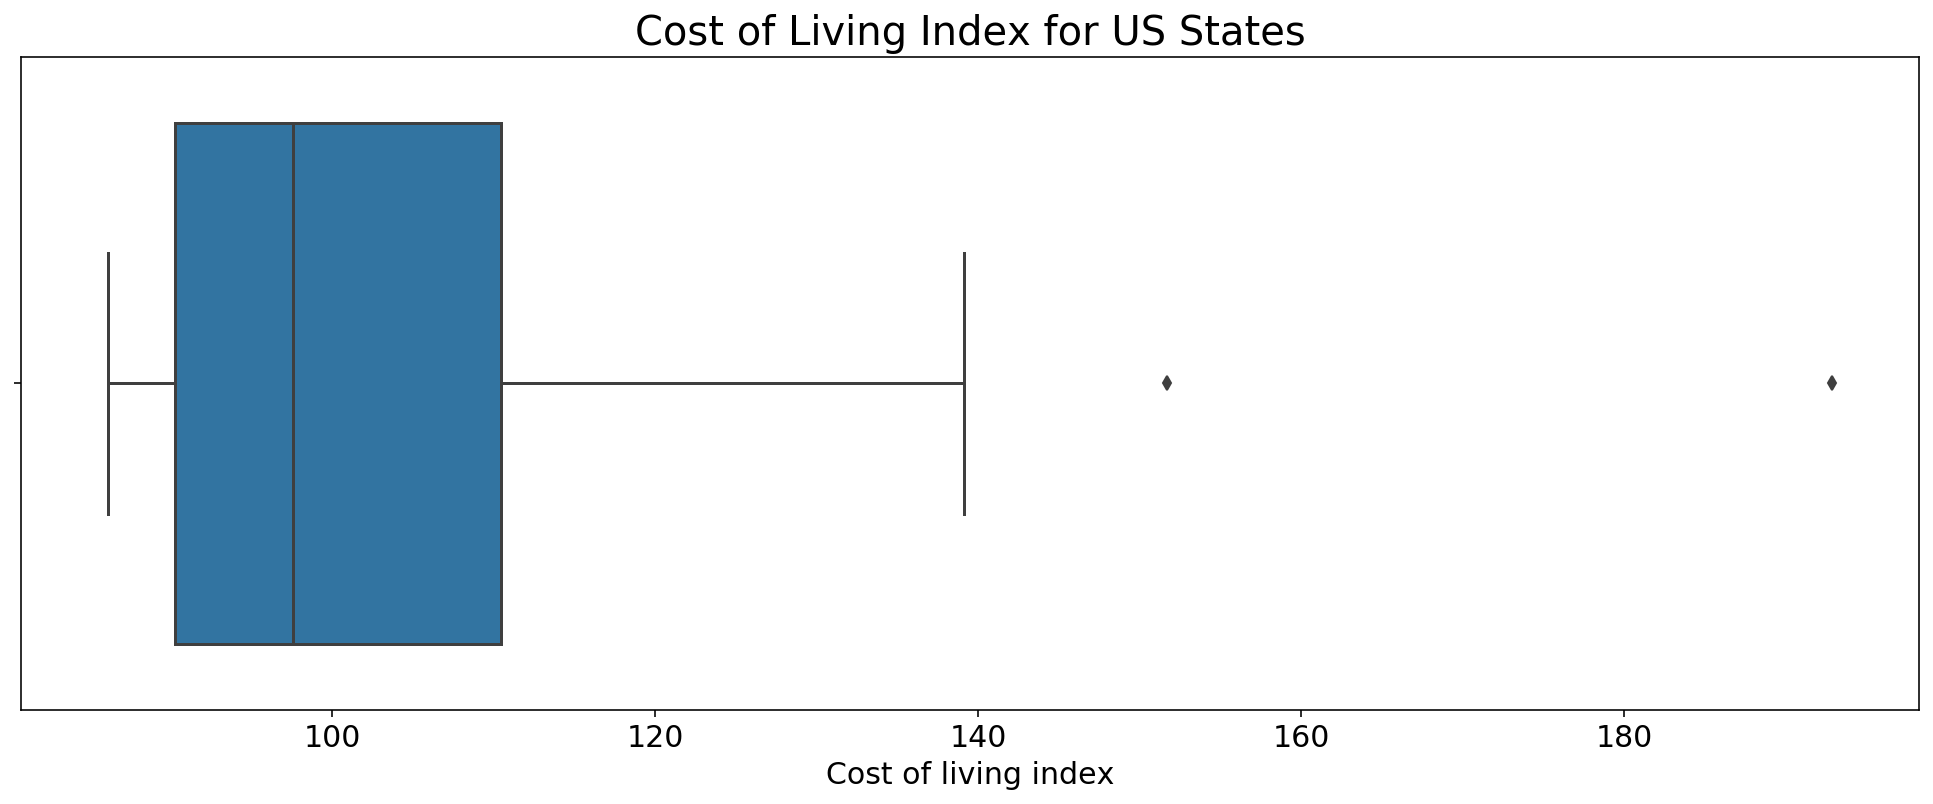

In [92]:
plt.rcParams['figure.figsize'] = (17, 6)
col_boxplot = sns.boxplot(x= 'costIndex', data= merged_df)
col_boxplot.set_title('Cost of Living Index for US States', fontsize= 20)
col_boxplot.set_xlabel('Cost of living index', fontsize= 15)
plt.xticks(fontsize=15)

In [93]:
# look at outliers
merged_df[merged_df['costIndex'] > 140]

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
4,California,47,136,3456.025,28.540000,3484.560000,151.7
10,Hawaii,2,3,9.985,0.026667,10.011667,192.9


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.]),
 <a list of 9 Text xticklabel objects>)

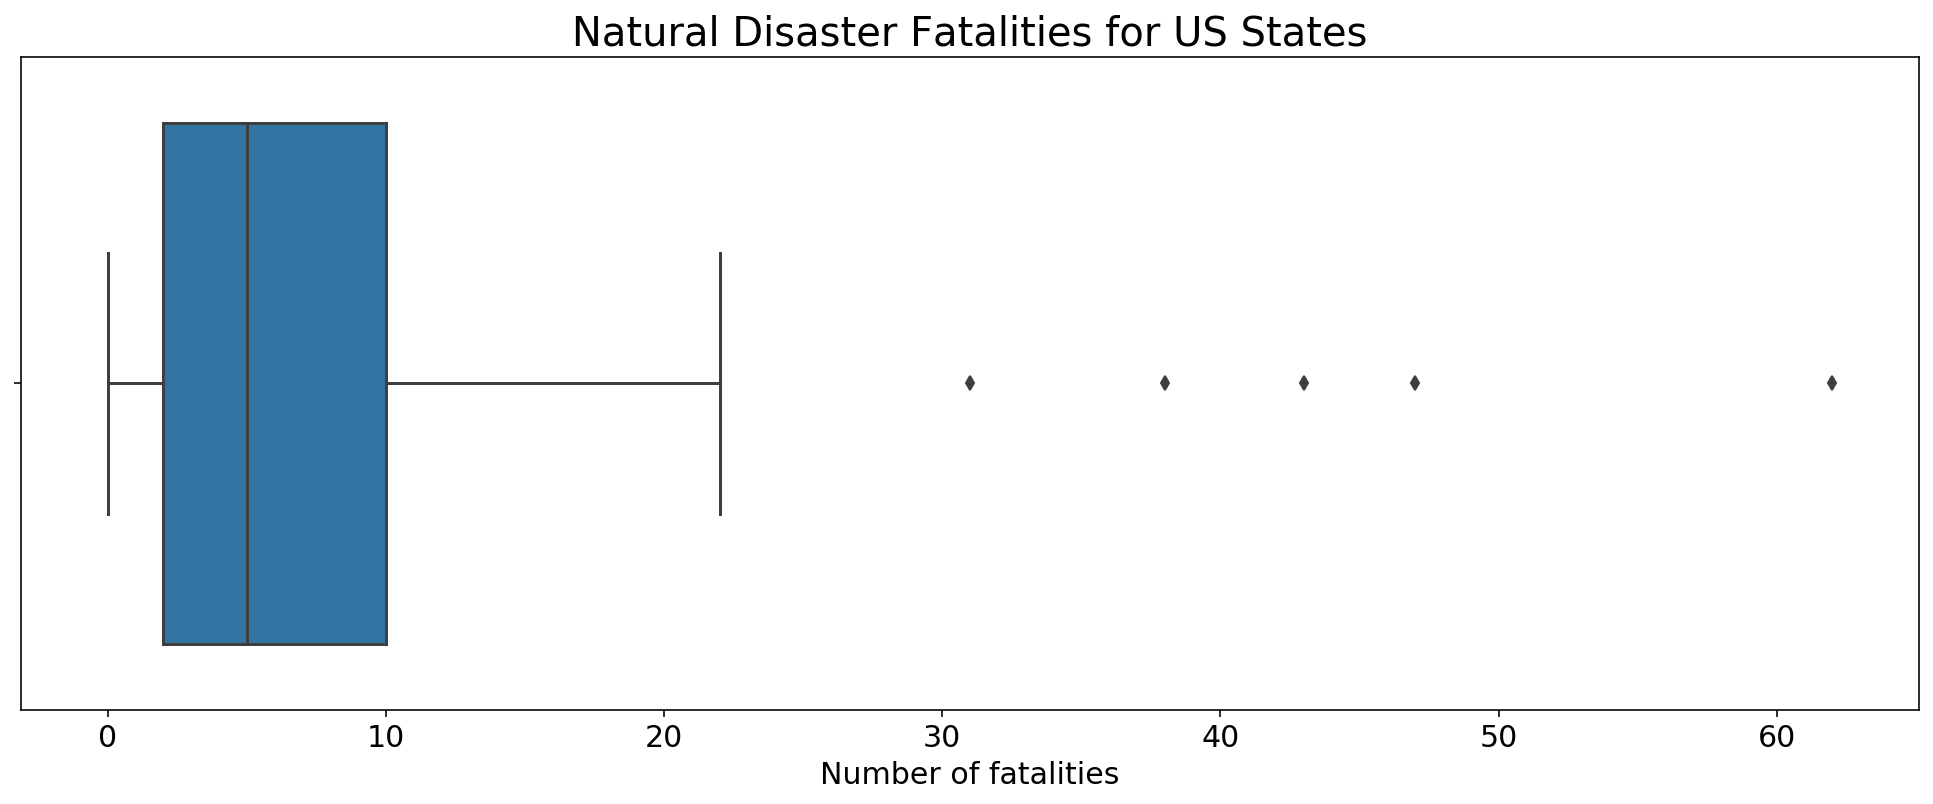

In [94]:
fatalities_boxplot = sns.boxplot(x= 'fatalities', data= merged_df)
fatalities_boxplot.set_title('Natural Disaster Fatalities for US States', fontsize= 20)
fatalities_boxplot.set_xlabel('Number of fatalities', fontsize= 15)
plt.xticks(fontsize=15)

In [113]:
# look at outliers
merged_df[merged_df['fatalities'] > 25]

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
2,Arizona,38,28,19.115000,0.775000,19.890000,97.0
4,California,47,136,3456.025000,28.540000,3484.560000,151.7
8,Florida,31,61,2893.845000,370.981667,3264.826667,97.9
27,Nevada,43,7,20.563333,0.000000,20.563333,108.5
42,Texas,62,173,12556.576667,125.370000,12681.946667,91.5


In [95]:
top10_fatalities = merged_df.sort_values(by= 'fatalities', ascending= False).head(10)
top10_fatalities

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
42,Texas,62,173,12556.576667,125.370000,12681.946667,91.5
4,California,47,136,3456.025000,28.540000,3484.560000,151.7
27,Nevada,43,7,20.563333,0.000000,20.563333,108.5
2,Arizona,38,28,19.115000,0.775000,19.890000,97.0
8,Florida,31,61,2893.845000,370.981667,3264.826667,97.9
32,North Carolina,22,19,528.508333,101.398333,629.905000,94.9
0,Alabama,13,42,62.233333,0.346667,62.580000,89.3
41,Tennessee,13,69,318.650000,0.580000,319.230000,88.7
12,Illinois,12,30,66.075000,2.590000,68.663333,94.5
24,Missouri,12,114,84.230000,3.913333,88.145000,87.1


(array([-25.,   0.,  25.,  50.,  75., 100., 125., 150., 175., 200.]),
 <a list of 10 Text xticklabel objects>)

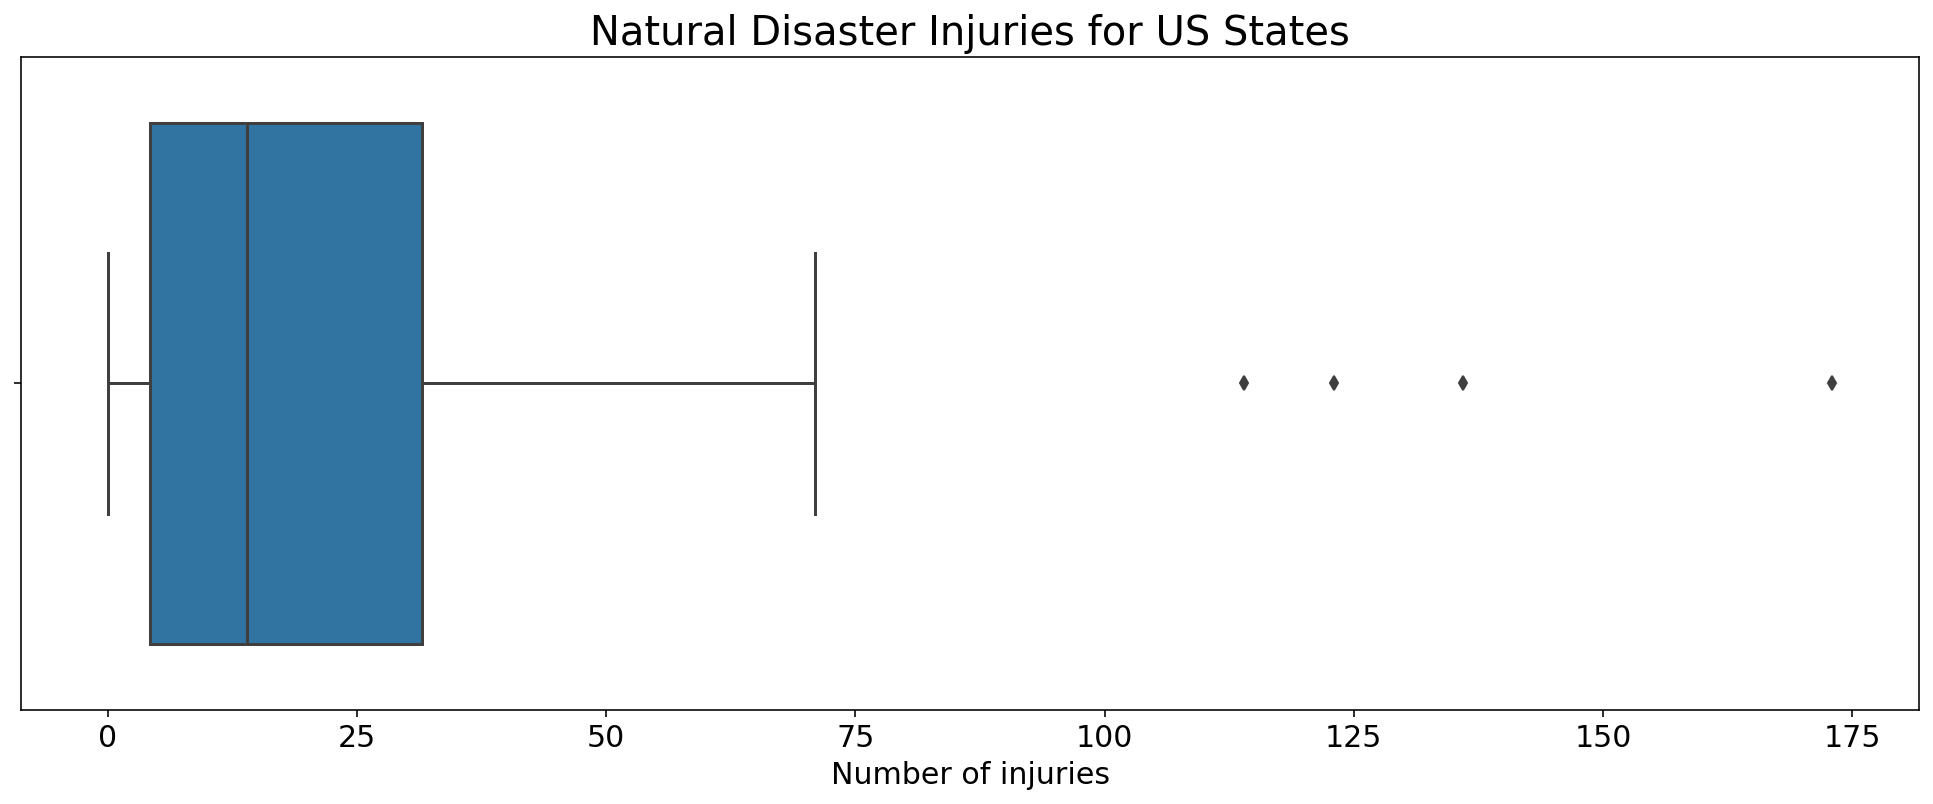

In [96]:
injuries_boxplot = sns.boxplot(x= 'injuries', data= merged_df)
injuries_boxplot.set_title('Natural Disaster Injuries')
injuries_boxplot.set_title('Natural Disaster Injuries for US States', fontsize= 20)
injuries_boxplot.set_xlabel('Number of injuries', fontsize= 15)
plt.xticks(fontsize=15)

In [112]:
# look at outliers
merged_df[merged_df['injuries'] > 75]

,state,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
4,California,47,136,3456.025000,28.540000,3484.560000,151.7
24,Missouri,12,114,84.230000,3.913333,88.145000,87.1
35,Oklahoma,10,123,51.871667,0.006667,51.880000,87.0
42,Texas,62,173,12556.576667,125.370000,12681.946667,91.5


(array([ 0.,  5., 10., 15., 20., 25., 30., 35.]),
 <a list of 8 Text yticklabel objects>)

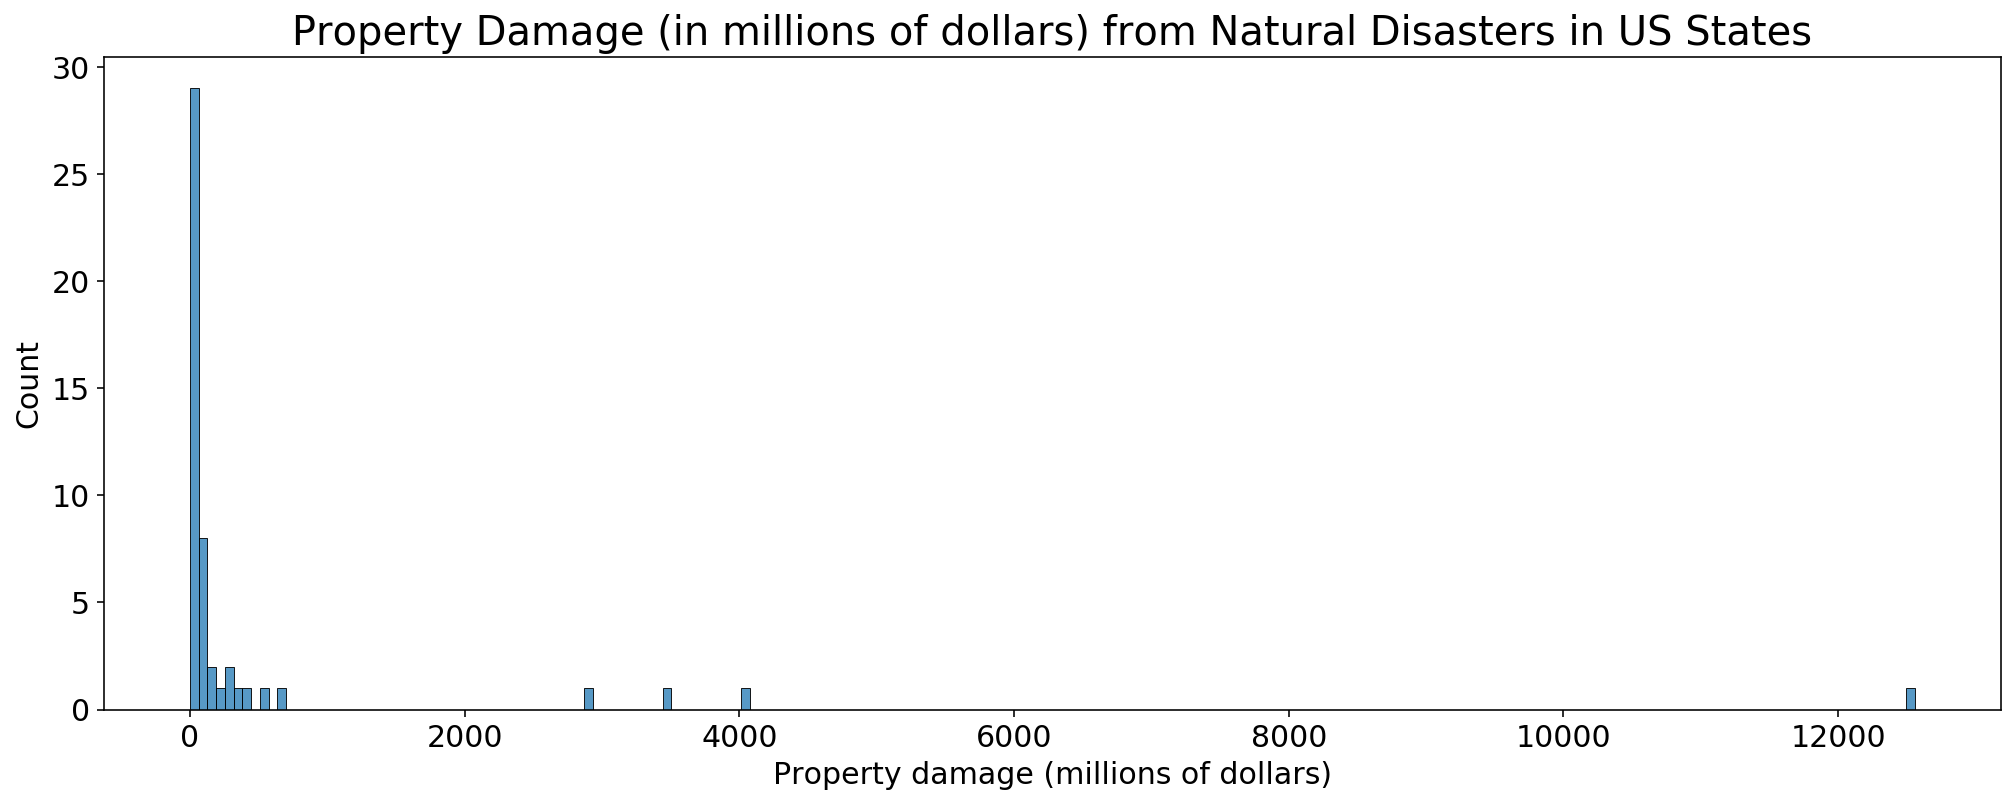

In [111]:
property_damage_hist = sns.histplot(x= 'property_damage', data= merged_df)
property_damage_hist.set_title('Property Damage (in millions of dollars) from Natural Disasters in US States', 
                               fontsize= 20)
property_damage_hist.set_xlabel('Property damage (millions of dollars)', fontsize= 15)
property_damage_hist.set_ylabel('Count', fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([ 80., 100., 120., 140., 160., 180., 200.]),
 <a list of 7 Text yticklabel objects>)

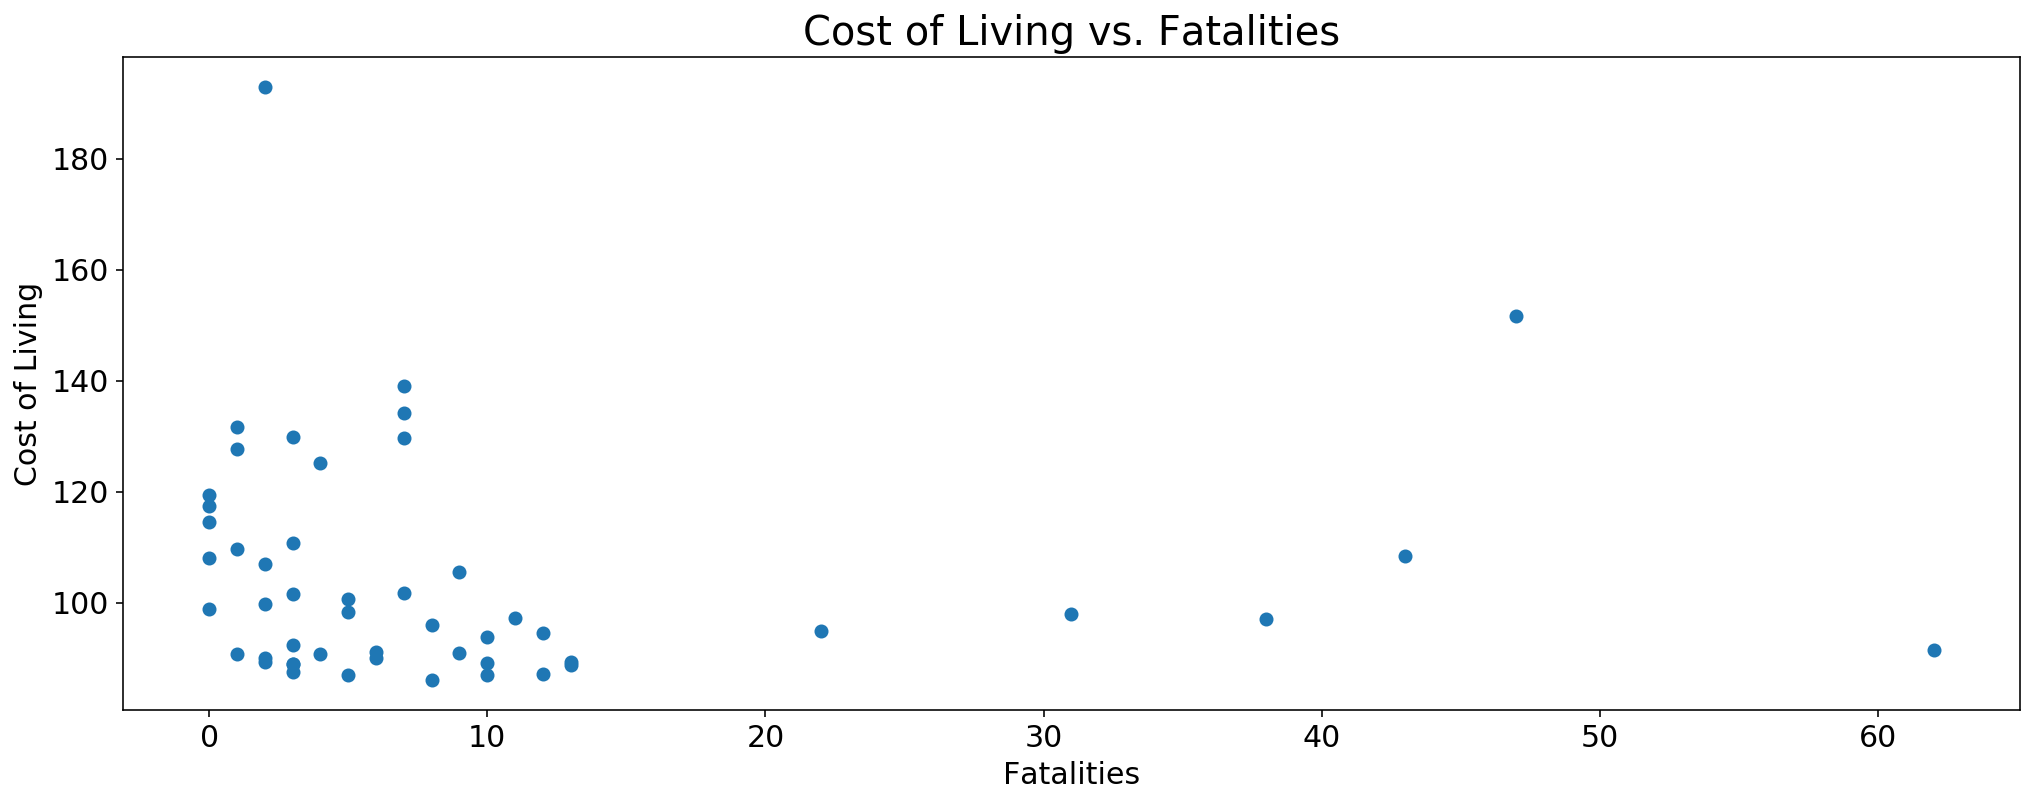

In [128]:
fatalities_col_scatterplot = plt.scatter(x= 'fatalities', y= 'costIndex', data= merged_df)
plt.title('Cost of Living vs. Fatalities', fontsize= 20)
plt.xlabel('Fatalities', fontsize= 15)
plt.ylabel('Cost of Living', fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([ 80., 100., 120., 140., 160., 180., 200.]),
 <a list of 7 Text yticklabel objects>)

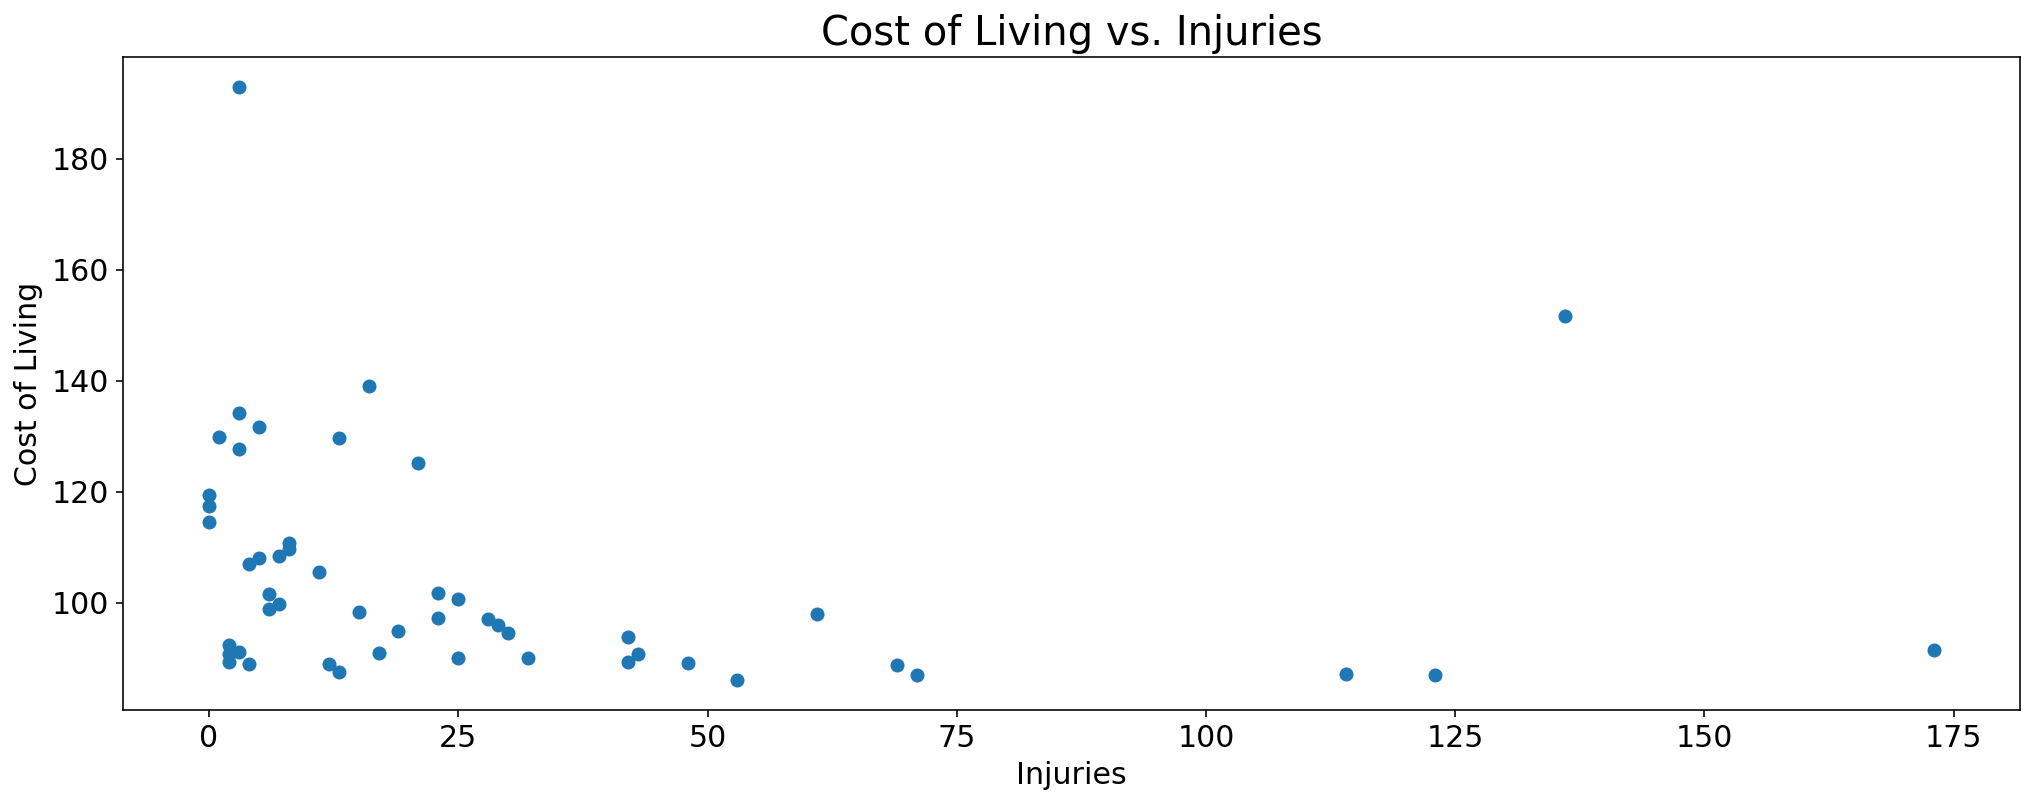

In [129]:
plt.scatter(x= 'injuries', y= 'costIndex', data= merged_df)
plt.title('Cost of Living vs. Injuries', fontsize= 20)
plt.xlabel("Injuries", fontsize= 15)
plt.ylabel("Cost of Living", fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

(array([ 80., 100., 120., 140., 160., 180., 200.]),
 <a list of 7 Text yticklabel objects>)

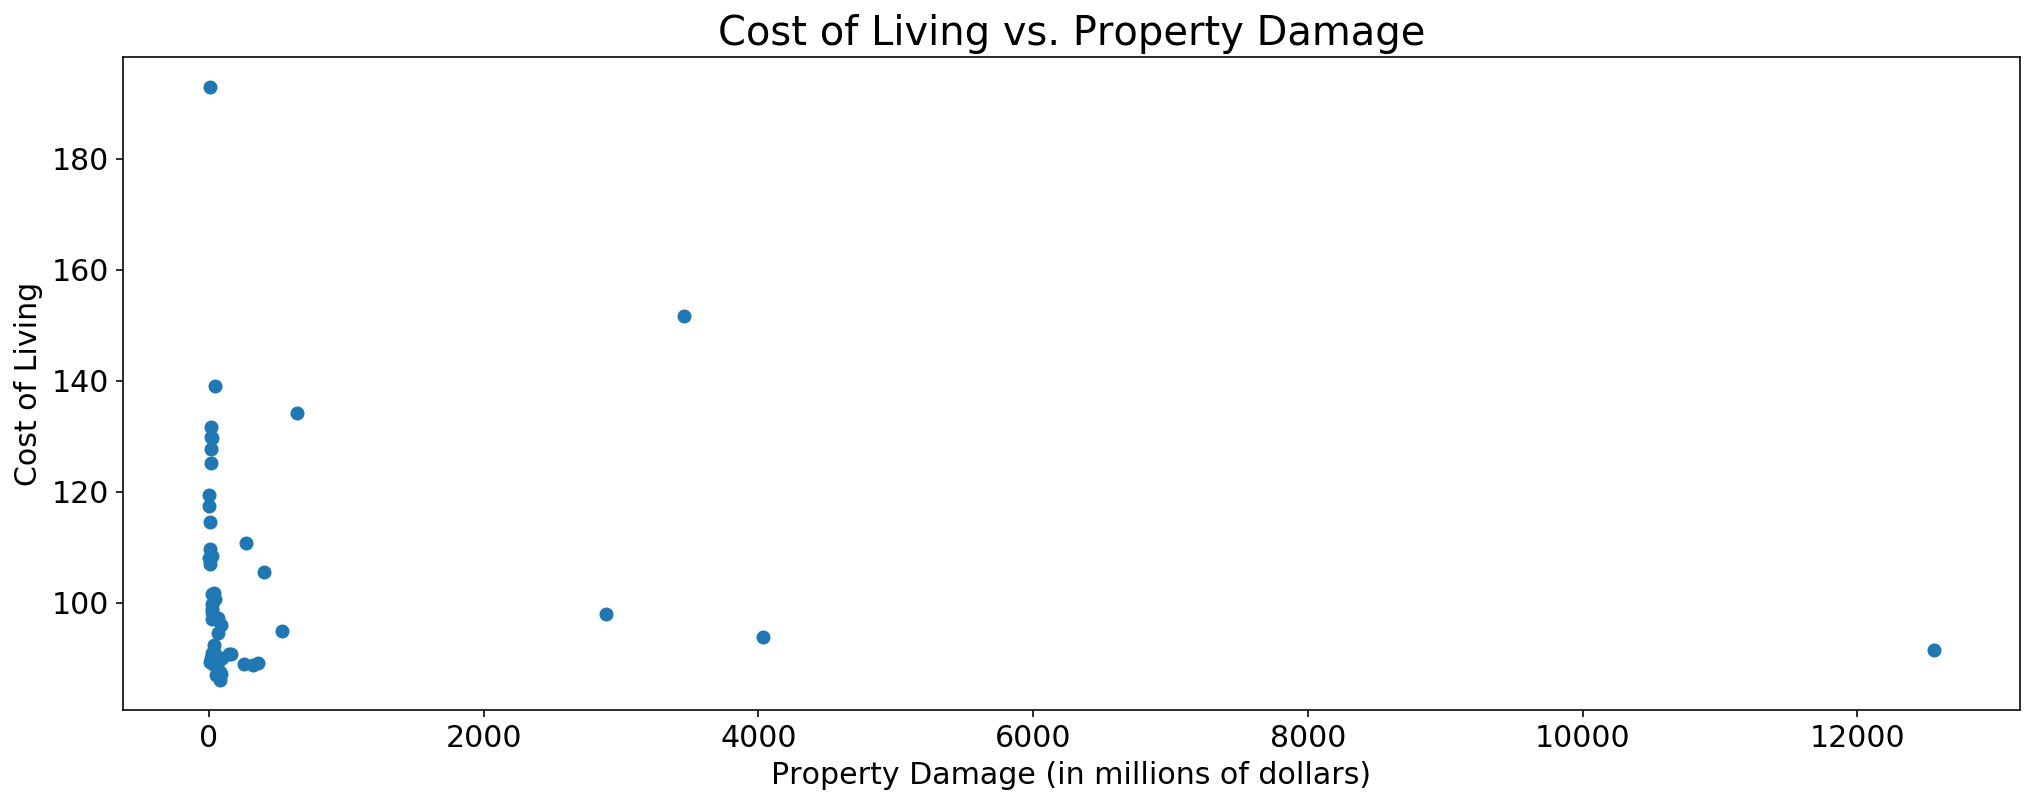

In [130]:
plt.scatter(x= 'property_damage', y= 'costIndex', data= merged_df)
plt.title('Cost of Living vs. Property Damage', fontsize= 20)
plt.xlabel("Property Damage (in millions of dollars)", fontsize= 15)
plt.ylabel("Cost of Living", fontsize= 15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [101]:
# calculate the following correlations: cost of living with injuries, cost of living with fatalities, cost of living with property damage

cols_of_interest= ['injuries', 'fatalities', 'property_damage']
correlation_lst = []

for col in cols_of_interest:
    correlation = merged_df['costIndex'].corr(merged_df[col])
    correlation_lst.append(correlation)

In [102]:
correlation_lst

[-0.1923227326260549, -0.02770036026462961, -0.03989881999876398]

In [103]:
merged_df.corr()

,fatalities,injuries,property_damage,crop_damage,total_damage,costIndex
fatalities,1.000000,0.658607,0.701369,0.249536,0.704437,-0.027700
injuries,0.658607,1.000000,0.657714,0.219319,0.659885,-0.192323
property_damage,0.701369,0.657714,1.000000,0.242143,0.998912,-0.039899
crop_damage,0.249536,0.219319,0.242143,1.000000,0.287125,-0.166547
total_damage,0.704437,0.659885,0.998912,0.287125,1.000000,-0.047396
costIndex,-0.027700,-0.192323,-0.039899,-0.166547,-0.047396,1.000000


In [104]:
combined_disasters

,year,state,fatalities,injuries,property_damage,crop_damage,total_damage,state_abbrv
0,2015,Alabama,13,17,14.79,0.00,14.79,AL
1,2015,Alaska,7,8,25.00,0.00,25.00,AK
2,2015,Arizona,8,58,10.74,0.05,10.79,AZ
3,2015,Arkansas,10,337,18.25,27.26,45.51,AR
4,2015,California,12,40,108.51,0.20,108.71,CA
...,...,...,...,...,...,...,...,...
295,2020,Virginia,1,14,41.29,0.10,41.39,VA
296,2020,Washington,5,11,1340.16,0.52,1340.68,WA
297,2020,West Virginia,1,3,5.62,0.00,5.62,WV
298,2020,Wisconsin,11,1,79.28,0.26,79.54,WI


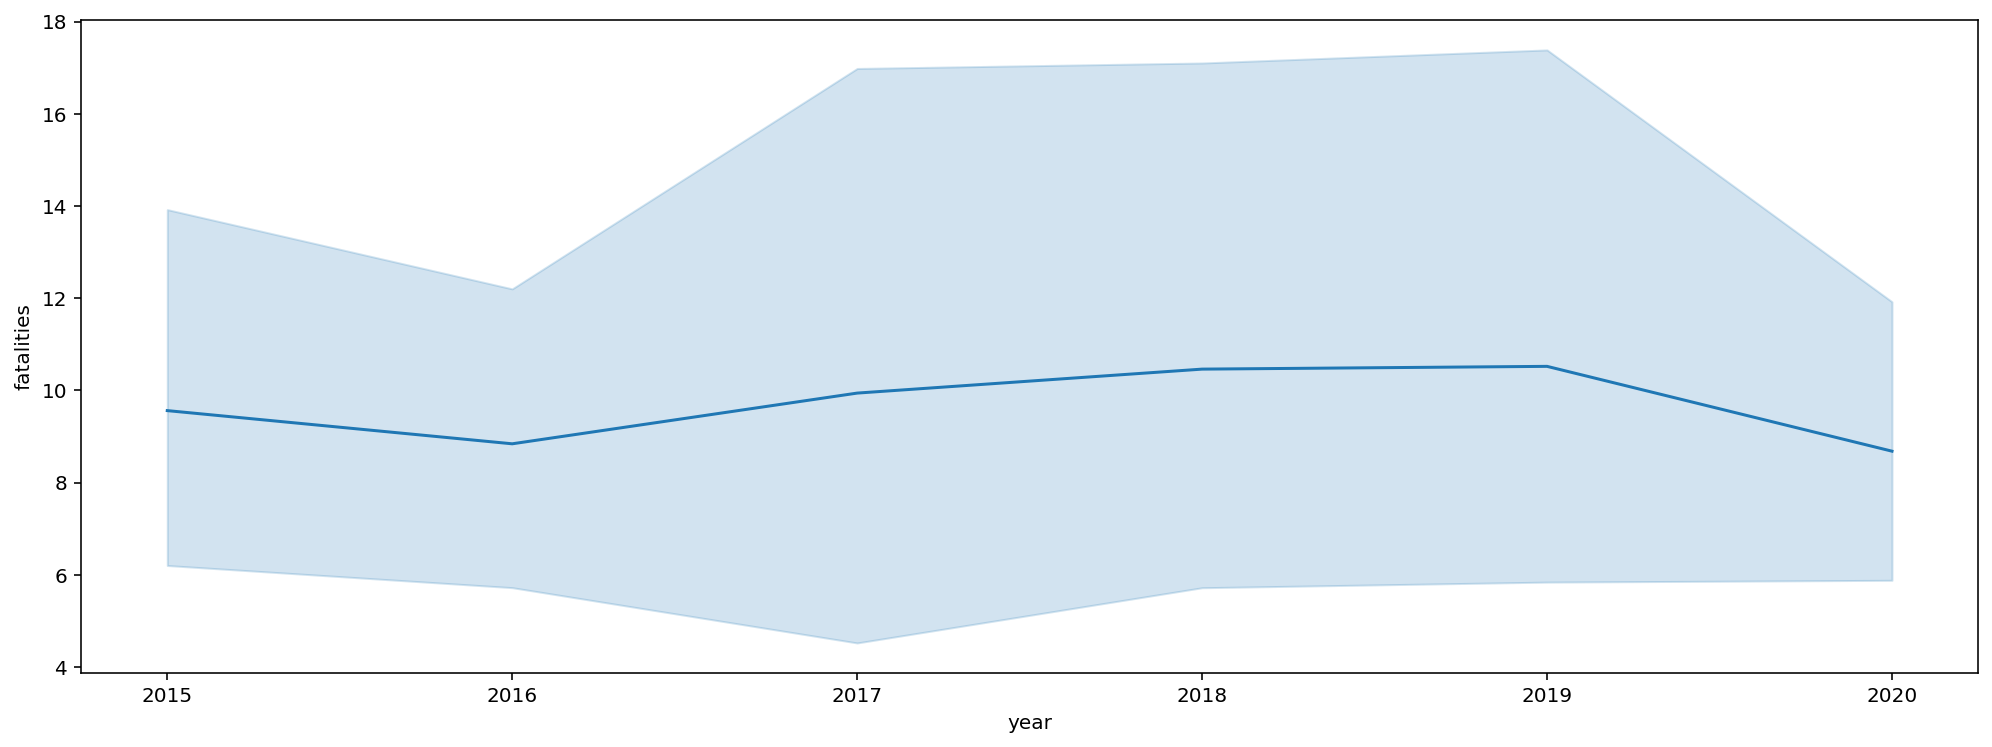

In [105]:
sns.lineplot(x= 'year', y= 'fatalities', data= combined_disasters)

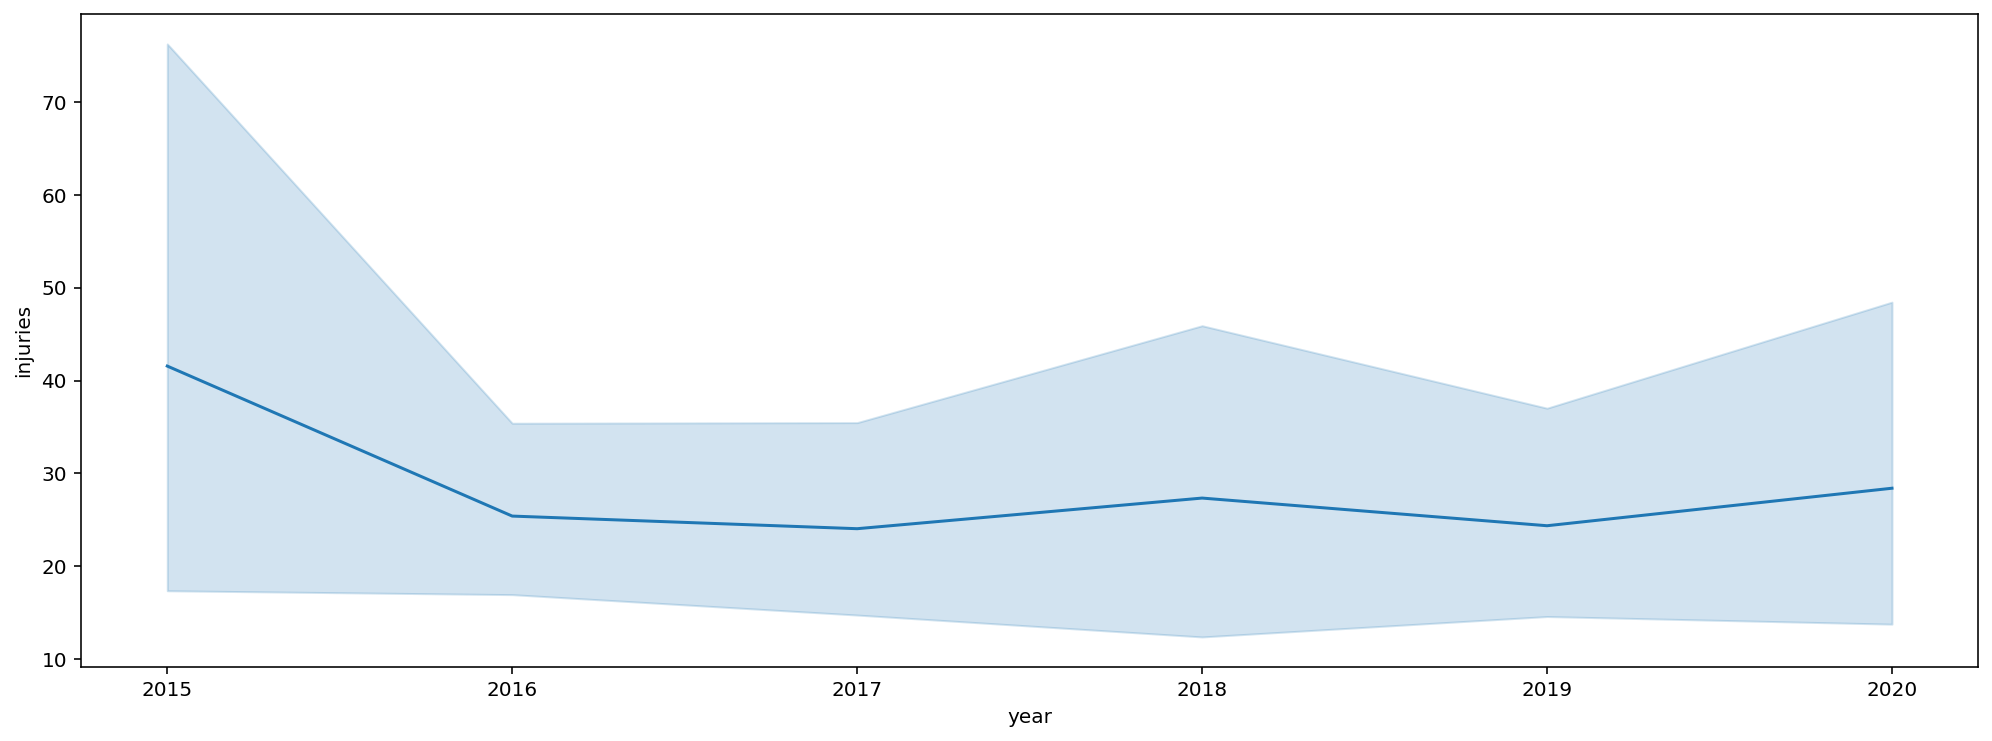

In [106]:
sns.lineplot(x= 'year', y= 'injuries', data= combined_disasters)